We preprocess images which have handwritten digits. We find the bounding box first.

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import skimage as ski
from skimage import io,transform

In [2]:
I = ski.io.imread('./data/WhatsApp Image 2017-10-14 at 3.18.01 PM.jpeg') # is clean
# I = ski.io.imread('./data/WhatsApp Image 2017-10-14 at 3.18.00 PM.jpeg') # has an unwanted huge shadow

# help(ski.transform.rescale) # DO THIS LATER. RESIZE INPUT IMAGE SO IT HAS UPPER BOUNDS ON SIZE

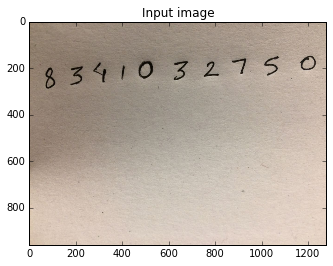

In [3]:
plt.imshow(I)
plt.title('Input image')

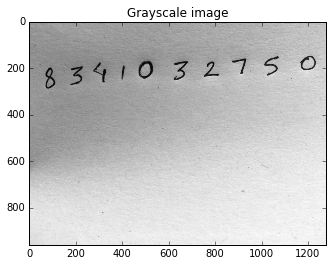

In [4]:
I_gray = ski.color.rgb2gray(I)
plt.imshow(I_gray, cmap='gray')
plt.title('Grayscale image')

The thresholding methods I used below were borrowed/adapted from here http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html

In [5]:
# from skimage.filters import threshold_local

In [6]:
# local_block_size = 101
# I_ = ski.filters.threshold_otsu(I_gray)
# # I_ = ski.filters.threshold_local(I_gray, local_block_size, offset=50)
# I_thresh = I_gray > I_
# plt.imshow(I_thresh, cmap='gray')
# # plt.imshow(I_, cmap='gray')
# plt.title('Thresholded image')

In [7]:
# from skimage.morphology import disk
# from skimage.filters import threshold_otsu, rank
# from skimage.util import img_as_ubyte

In [8]:
# radius = 300
# selem = disk(radius)

# I_gray_ = ski.img_as_ubyte(I_gray)
# I_ = rank.otsu(I_gray_, selem) # local otsu
# # I_ = threshold_otsu(I_gray_)
# # global_otsu = I_ < I_gray_
# plt.imshow(I_, cmap='gray')
# plt.title('Pre-thresholding image')

/usr/lib64/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


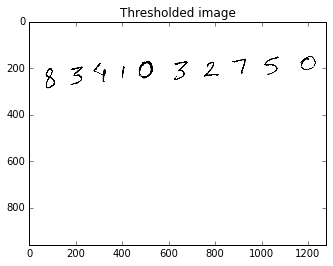

In [9]:
############################################
# Finally, we try a dumb hard threshold :o #
############################################
I_gray_ = ski.img_as_ubyte(I_gray)
I_ = 50
I_thresholded = I_ < I_gray_
plt.imshow(I_thresholded, cmap='gray')
plt.title('Thresholded image')

Now we crop it.

In [10]:
def auto_crop (I):
    """Find bounding box of image, crop to this box, and return a view
    of this (use numpy.copy on the returned object, if needed).
    Assumes background pixels have value '1'."""
    row_sum = (1 - I).sum(axis=1)
    col_sum = (1 - I).sum(axis=0)
    top = np.nonzero(row_sum)[0][0]
    bottom = np.nonzero(row_sum)[0][-1]
    left = np.nonzero(col_sum)[0][0]
    right = np.nonzero(col_sum)[0][-1]

    # print(left, right, top, bottom)
    return I[top:bottom,left:right]

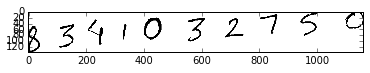

In [11]:
I_cropped = auto_crop(I_thresholded)
plt.imshow(I_cropped, cmap='gray')

In [12]:
###########################################
# Now segment this into individal digits. #
###########################################
import scipy as sp
from scipy import signal

[   0   61  182  288  374  485  628  754  886 1020 1161]


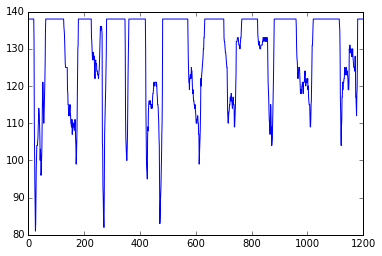

In [13]:
intensities_horz = I_cropped.sum(axis=0)
# we seem to need to pad it, for wavelet transform based peak detection to work properly
intensities_horz = np.pad(intensities_horz, 20, mode='constant', constant_values=1*I_cropped.shape[0])
plt.plot(intensities_horz)
peak_locs = sp.signal.find_peaks_cwt(intensities_horz,np.arange(20,70))
peak_locs = np.maximum(np.array(peak_locs) - 20, 0)
print(peak_locs)

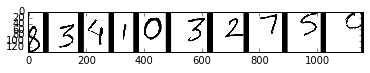

In [14]:
######################################
# show the segmenting boundary lines #
######################################
I_segmented = I_cropped.copy()
for x in peak_locs:
    I_segmented[:, x-10:x+10] = 0
plt.imshow(I_segmented, cmap='gray')

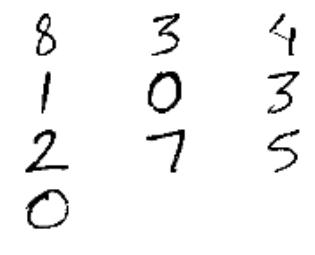

In [15]:
#####################################################################
# Segment into multiple individual digit images in the MNIST format #
#####################################################################
digits=[]
for i in xrange(0, len(peak_locs) - 1):    
    digit = I_cropped[:, peak_locs[i]:peak_locs[i+1]];
    digit = auto_crop(digit).copy()
    
    # resize it
    s = np.array(digit.shape);
    s = ((24.0*s/s.max()).round().astype('int'))
    digit = ski.transform.resize(digit, s, order=3, mode='constant')
    # pad it
    pad_l = np.floor((28 - s[0])/2).astype('int')
    pad_r = 28 - s[0] - pad_l
    pad_t = np.floor((28 - s[1])/2).astype('int')
    pad_b = 28 - s[1] - pad_t    
    # print ([pad_l,pad_r],[pad_t,pad_b])
    digit = np.pad(digit, [[pad_l,pad_r],[pad_t,pad_b]], mode='constant', constant_values=1)
    # print(digit.shape)
    
    digits.append(digit)

#############################
# show the segmented digits #
#############################
for i in xrange(len(digits)):
    plt.subplot(4,3,i+1)
    plt.axis('off')
    plt.imshow(digits[i],cmap='gray')